In [1]:
import warnings
import sys
warnings.filterwarnings("ignore", message="Trying algorithm eng36")
sys.stderr = open('/dev/null', 'w') if sys.platform.startswith('linux') or sys.platform.startswith('darwin') else open('nul', 'w')

Warning block 👆

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.saving import load_model
import numpy as np
from keras.callbacks import ModelCheckpoint

In [3]:
data_dir = '/kaggle/input/apparel-dataset'

#### directory names

In [4]:
import os


# Function to print directory tree recursively
def print_directory_tree(directory, indent=''):
    for item in os.listdir(directory):
        full_path = os.path.join(directory, item)
        if os.path.isdir(full_path):
            print(indent + item + '/')
            print_directory_tree(full_path, indent + '    ')

# Print the directory tree
print_directory_tree(data_dir)

yellow_skirt/
white_pants/
white_suit/
black_pants/
white_shoes/
pink_hoodie/
brown_shoes/
blue_shirt/
green_shoes/
blue_pants/
white_shorts/
red_pants/
blue_shoes/
black_dress/
red_shirt/
red_hoodie/
green_pants/
black_shorts/
black_suit/
red_shoes/
yellow_dress/
pink_pants/
yellow_shorts/
blue_dress/
black_shirt/
red_dress/
green_shirt/
brown_hoodie/
silver_shoes/
white_dress/
pink_skirt/
green_shorts/
silver_skirt/
green_suit/
blue_shorts/
brown_pants/
black_shoes/


### Data preprocess

In [5]:
dataset_apparel = image_dataset_from_directory(
    directory = data_dir,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=16,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='both',#if subset = both it returns train and validation set respectively
)

Found 16170 files belonging to 37 classes.
Using 12936 files for training.
Using 3234 files for validation.


In [6]:
for labels in dataset_apparel:
  print(labels)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 37), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 37), dtype=tf.float32, name=None))>


In [7]:
train_set, validation_set = dataset_apparel

### Model Checkpoint method

In [8]:
checkpoint_path = '/kaggle/working/model_checkpoint.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='auto',
    save_best_only=True,
    verbose=1)

### Built Model

In [9]:
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    
    layers.Conv2D(512, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2), 
    
    layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(37, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',#multilabel classification
              metrics=['accuracy','auc'])

### Run Model

In [10]:
history = model.fit(train_set, epochs=10, validation_data=validation_set, callbacks=[model_checkpoint_callback])

print("------------*************------------")
test_loss, test_acc, test_auc = model.evaluate(validation_set)
print(f"Test accuracy: {test_acc}")

Epoch 1/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.4182 - auc: 0.8876 - loss: 2.9918
Epoch 1: val_accuracy improved from -inf to 0.61503, saving model to /kaggle/working/model_checkpoint.keras
809/809 ━━━━━━━━━━━━━━━━━━━━ 363s 373ms/step - accuracy: 0.4184 - auc: 0.8876 - loss: 2.9911 - val_accuracy: 0.6150 - val_auc: 0.9674 - val_loss: 1.9776
Epoch 2/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.6700 - auc: 0.9745 - loss: 1.7246
Epoch 2: val_accuracy did not improve from 0.61503
809/809 ━━━━━━━━━━━━━━━━━━━━ 258s 319ms/step - accuracy: 0.6700 - auc: 0.9745 - loss: 1.7245 - val_accuracy: 0.5442 - val_auc: 0.9554 - val_loss: 2.0766
Epoch 3/10
809/809 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.7142 - auc: 0.9829 - loss: 1.4876
Epoch 3: val_accuracy did not improve from 0.61503
809/809 ━━━━━━━━━━━━━━━━━━━━ 257s 317ms/step - accuracy: 0.7143 - auc: 0.9829 - loss: 1.4876 - val_accuracy: 0.5881 - val_auc: 0.9610 - val_loss: 2.0173
Epoch 4/10
809/809 ━━━━━━

### Plot performance graph

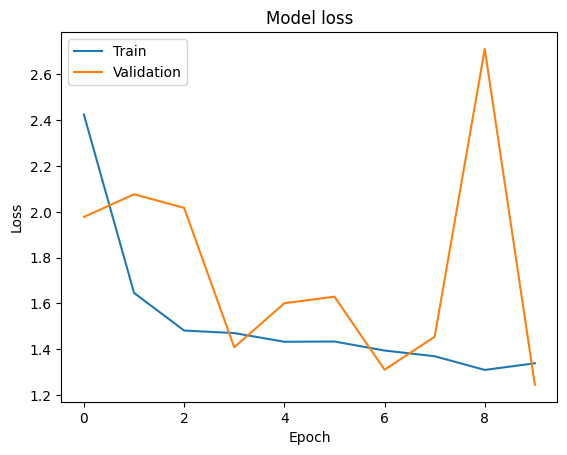

203/203 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step


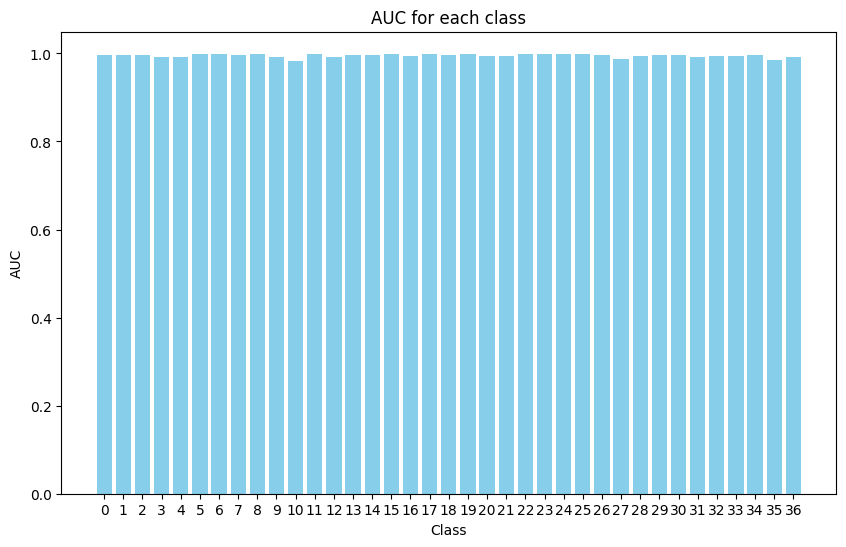

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import pandas as pd

# ploting loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#AUC-ROC
y_true = np.concatenate([y for x, y in validation_set], axis=0)
y_pred = model.predict(validation_set)

auc_scores = []
for i in range(y_true.shape[1]):
    auc = roc_auc_score(y_true[:, i], y_pred[:, i])
    auc_scores.append(auc)
    
class_names = list(range(y_true.shape[1])) 
df_auc = pd.DataFrame({'Class': class_names, 'AUC': auc_scores})
plt.figure(figsize=(10, 6))
plt.bar(df_auc['Class'], df_auc['AUC'], color='skyblue')
plt.xlabel('Class')
plt.ylabel('AUC')
plt.title('AUC for each class')
plt.xticks(class_names)
plt.show()

In [12]:
load_save_model = load_model('/kaggle/working/model_checkpoint.keras', custom_objects=None, compile=True, safe_mode=True)